# Compairing QTLs for Tomato fruit shape & Potato tuber shape on Chromosome 10

*Matthijs, Gurnoor, Arnold*

<div class=text-justify>
Reference tomato have a round fruit shape, while reference potatoes have an elongated tuber shape. Recently published article ( <a href="https://dx.doi.org/10.1038%2Fs41467-018-07216-8">DOI:10.1038/s41467-018-07216-8</a>) reveals that the presence of SLOFP20 on chromosome 10 of tomatoes is responsible for the roundness in fruit shape. However, there is no ortholog of this SLOFP20 in the reference potato DM, and this contributes to elongated tuber. In our python application we map the QTL regions in both tomato and potato, to check how well genes in both the QTL map. Consequently,  we classify genes into 3 categories, genes that occur both in tomato and potato, gene that are unique in tomato, and genes that are unique in potato. Further, we query the GO annotations in every class to see if there is any difference in GO annotations based on classes. This to find a uniqueness of every gene class.

Lastly, we summaries all the properties of the gene SLOFP20 from SGN, Uniprot and Ensembleplants database. 
</div>


Potato markers in the region pPt-458713 and pPt-473367 where as Tomato markers in the region are solcap_snp_sl_26447 and  gene188_0-i21

## Initialization

In [1]:
import orthologs
import pandas as pd
from IPython.display import Image,SVG
search = orthologs.SEARCH("http://pbg-ld.candygene-nlesc.surf-hosted.nl:8088/api/candYgene/queries", "http://pbg-ld.candygene-nlesc.surf-hosted.nl:8890/sparql")

QTL for fruit shape in tomatoes on chromosome 10 is marked by the genes Solyc10g075170 and Solyc10g076240. Similarly QTL for tuber shape in potatoes on chromosome 10 is marked by the genes PGSC0003DMG400006678 and PGSC0003DMG400020801.


In [2]:
#potato
pg1 = "PGSC0003DMG400006678"
pg2 = "PGSC0003DMG400020801"
#tomato
tg1 = "Solyc10g075170.1"
tg2 = "Solyc10g076240.1"


## Tomato

### Find co-ordinates of the QTL interval
Search locations of genes, and compute interval

In [3]:
intervalT = search.compute_interval(tg1, tg2)

,location,taxon_id
gene_id,,
Solyc10g075170.1,chromosome 10:58891402-58895882,4081
Solyc10g076240.1,chromosome 10:59082990-59084119,4081


### List the candidate genes inside this QTL interval and search potato orthologs
List genes and potato orthologs inside this interval

In [4]:
genesT = search.interval_genes(intervalT)
aggregations = { "ortholog_gene_id" : ["nunique"]}
display(genesT.groupby(["gene_id"]).agg(aggregations))

,ortholog_gene_id
,nunique
gene_id,
PGSC0003DMG400011413,1
PGSC0003DMG400011414,1
PGSC0003DMG400011415,1
PGSC0003DMG400011426,1
PGSC0003DMG400011429,0
PGSC0003DMG400011430,1
PGSC0003DMG400011431,1
PGSC0003DMG400011432,1


### List orthologs
List orthologs for the genes found in the interval

In [5]:
#df2=genesT[["location","ortholog_gene_id","ortholog_location"]].groupby(["gene_id"])
#df2.describe()
index=pd.MultiIndex.from_tuples([tuple(x) for x in genesT[["location","ensembl_gene_id", "ortholog_gene_id"]].to_records()], names=["gene_id", "location", "ensembl_gene_id", "ortholog_gene_id"])
display(genesT.set_index(index)[["ortholog_location"]])             

,,,,ortholog_location
gene_id,location,ensembl_gene_id,ortholog_gene_id,
PGSC0003DMG400011443,chromosome 10:58906247-58907229,PGSC0003DMG400011443,Solyc10g078800.1,chromosome 10:60494959-60502913:-1
PGSC0003DMG402011442,chromosome 10:58909999-58912502,PGSC0003DMG402011442,Solyc10g078810.1,chromosome 10:60505017-60506901:-1
PGSC0003DMG400011441,chromosome 10:58916393-58918781,PGSC0003DMG400011441,Solyc10g078800.1,chromosome 10:60494959-60502913:-1
PGSC0003DMG400011440,chromosome 10:58920720-58922388,PGSC0003DMG400011440,NaN,None
PGSC0003DMG400011415,chromosome 10:58925892-58928315,PGSC0003DMG400011415,Solyc10g078790.1,chromosome 10:60491110-60493017:1
PGSC0003DMG400011439,chromosome 10:58929125-58930303,PGSC0003DMG400011439,Solyc10g078780.1,chromosome 10:60488097-60489151:-1
PGSC0003DMG400011438,chromosome 10:58931638-58932735,PGSC0003DMG400011438,Solyc10g078770.1,chromosome 10:60481971-60482744:-1
PGSC0003DMG400011437,chromosome 10:58933783-58934530,PGSC0003DMG400011437,Solyc10g078760.1,chromosome 10:60479339-60479701:-1
PGSC0003DMG400011414,chromosome 10:58934720-58938447,PGSC0003DMG400011414,Solyc10g078750.1,chromosome 10:60475651-60478736:1


### Chromosomes for orthologs
Chromosomes containing the found orthologs

In [6]:
kauraggregations = {"ortholog_begin_pos" : ["min","max"], "ortholog_end_pos" : ["min","max"]}
display(genesT.groupby(["ortholog_begin_ref"]).agg(aggregations))

,ortholog_gene_id
,nunique
ortholog_begin_ref,
http://rdf.ebi.ac.uk/resource/ensembl/33/solanum_lycopersicum/SL2.50/10,16
http://rdf.ebi.ac.uk/resource/ensembl/33/solanum_tuberosum/SolTub_3.0/00,2
http://rdf.ebi.ac.uk/resource/ensembl/33/solanum_tuberosum/SolTub_3.0/10,4


### Diagram crosslinks
Create a diagram with crosslinks between found genes and orthologs

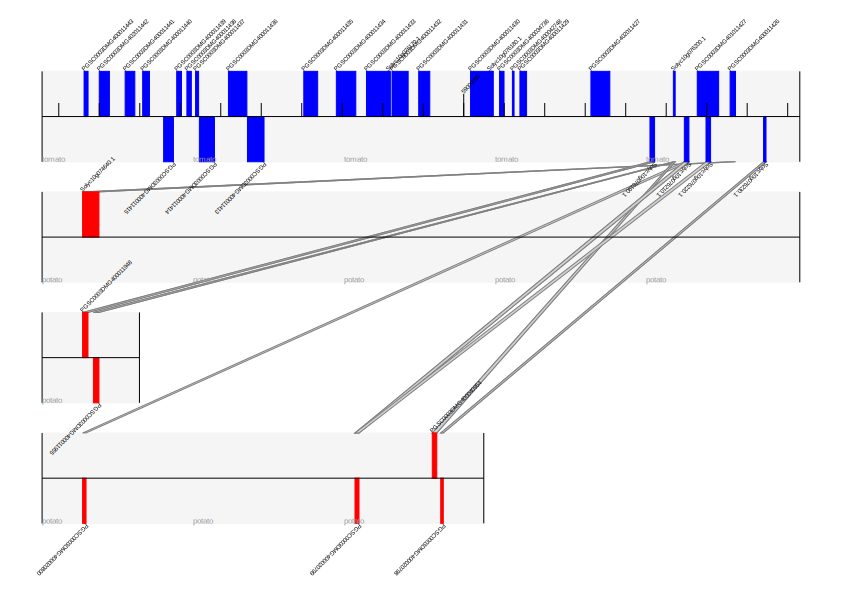

In [7]:
genesTdiagram = search.diagram_crosslinks("tomato", "potato", intervalT, genesT)
tmpFilename = "tomato_"+pg1+"-"+pg2+"_crosslinks.svg"
genesTdiagram.write(tmpFilename, "svg")
SVG(tmpFilename)

## Potato
### Find interval
Find locations for genes, and compute interval

In [8]:
intervalP = search.compute_interval(pg1, pg2)

,location,taxon_id
gene_id,,
PGSC0003DMG400006678,chromosome 10:48978066-48982521,4113
PGSC0003DMG400020801,chromosome 10:49258672-49260078,4113


### Find genes and orthologs
Find genes and orthologs for interval

In [9]:
genesP = search.interval_genes(intervalP)
aggregations = {"ensembl_gene_id" : ["nunique"], "ortholog_gene_id" : ["nunique"]}
display(genesP.groupby(["gene_id"]).agg(aggregations))

,ensembl_gene_id,ortholog_gene_id
,nunique,nunique
gene_id,,
PGSC0003DMG400006679,1,0
PGSC0003DMG400006680,1,0
PGSC0003DMG400006681,1,0
PGSC0003DMG400020795,1,0
PGSC0003DMG400020797,1,0
PGSC0003DMG400020798,1,2
PGSC0003DMG400020799,1,2
PGSC0003DMG400020800,1,2


### List orthologs
List orthologs for the genes found in the interval

In [10]:
#display(genesP[["location","ensembl_gene_id","ortholog_gene_id","ortholog_location"]])
index=pd.MultiIndex.from_tuples([tuple(x) for x in genesP[["location","ensembl_gene_id", "ortholog_gene_id"]].to_records()], names=["gene_id", "location", "ensembl_gene_id", "ortholog_gene_id"])
display(genesP.set_index(index)[["ortholog_location"]])

ortholog_location
gene_id              location                        ensembl_gene_id      ortholog_gene_id                                        
PGSC0003DMG400006679 chromosome 10:49022687-49023709 PGSC0003DMG400006679 NaN                                                 None
PGSC0003DMG400006680 chromosome 10:49040786-49046010 PGSC0003DMG400006680 NaN                                                 None
PGSC0003DMG400006681 chromosome 10:49064472-49065184 PGSC0003DMG400006681 NaN                                                 None
PGSC0003DMG400020800 chromosome 10:49084193-49085040 PGSC0003DMG400020800 Solyc10g076210.1      chromosome 10:59054478-59055612:-1
                                                                          Solyc10g076220.1      chromosome 10:59059828-59060961:-1
PGSC0003DMG400045482 chromosome 10:49092329-49093552 PGSC0003DMG400045482 NaN                                                 None
PGSC0003DMG400040544 chromosome 10:49108641-49111957 PGSC0003DMG400040544 Solyc01g066890.1       chromosome 1:75142075-75142941:-1
                                                                          Solyc07g041360.1       chromosome 7:52534390-52534818:-1
PGSC0003DMG400020799 chromosome 10:49151461-49152451 PGSC0003DMG400020799 Solyc10g076210.1      chromosome 10:59054478-59055612:-1
                                                                          Solyc10g076220.1      chromosome 10:59059828-59060961:-1
Solyc10g050340.1     chromosome 10:49163373-49163675 Solyc10g050340.1     NaN                                                 None
PGSC0003DMG400040954 chromosome 10:49170543-49171657 PGSC0003DMG400040954 Solyc10g076200.1       chromosome 10:59051770-59052216:1
Solyc10g050350.1     chromosome 10:49172027-49172476 Solyc10g050350.1     PGSC0003DMG400042496     chromosome 2:8977829-8982848:-1
                                                                          Solyc05g018860.1       chromosome 5:24295535-24297267:-1
                                                                          Solyc04g018050.1          chromosome 4:9128223-9129349:1
                                                                          PGSC0003DMG400039849   chromosome 11:18694341-18695718:1
                                                                          Solyc02g014410.1        chromosome 2:16254696-16255120:1
PGSC0003DMG400020798 chromosome 10:49172630-49173264 PGSC0003DMG400020798 Solyc10g076230.1      chromosome 10:59074041-59074647:-1
                                                                          Solyc10g075120.1       chromosome 10:58847992-58848834:1
PGSC0003DMG400035649 chromosome 10:49174387-49174710 PGSC0003DMG400035649 NaN                                                 None
PGSC0003DMG400020797 chromosome 10:49199138-49201970 PGSC0003DMG400020797 NaN                                                 None
Solyc10g050360.1     chromosome 10:49229728-49229934 Solyc10g050360.1     NaN                                                 None
PGSC0003DMG400039458 chromosome 10:49235999-49240574 PGSC0003DMG400039458 NaN                                                 None
PGSC0003DMG400020795 chromosome 10:49247297-49254377 PGSC0003DMG400020795 NaN                                                 None

### Chromosomes for orthologs
Chromosomes containing the found orthologs

In [11]:
aggregations = {"ortholog_begin_pos" : ["min","max"], "ortholog_end_pos" : ["min","max"]}
display(genesP.groupby(["ortholog_begin_ref"]).agg(aggregations))

ortholog_begin_pos  \
                                                                  min   
ortholog_begin_ref                                                      
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...         75142941.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...         58847992.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...         16254696.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...          9128223.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...         24297267.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...         52534818.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...         18694341.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...          8982848.0   

                                                                \
                                                           max   
ortholog_begin_ref                                               
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  75142941.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  59074647.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  16254696.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...   9128223.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  24297267.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  52534818.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  18694341.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...   8982848.0   

                                                   ortholog_end_pos  \
                                                                min   
ortholog_begin_ref                                                    
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...       75142075.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...       58848834.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...       16255120.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...        9129349.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...       24295535.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...       52534390.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...       18695718.0   
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...        8977829.0   

                                                                
                                                           max  
ortholog_begin_ref                                              
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  75142075.0  
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  59074041.0  
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  16255120.0  
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...   9129349.0  
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  24295535.0  
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  52534390.0  
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...  18695718.0  
http://rdf.ebi.ac.uk/resource/ensembl/33/solanu...   8977829.0

### Diagram crosslinks
Create a diagram with crosslinks between found genes and orthologs

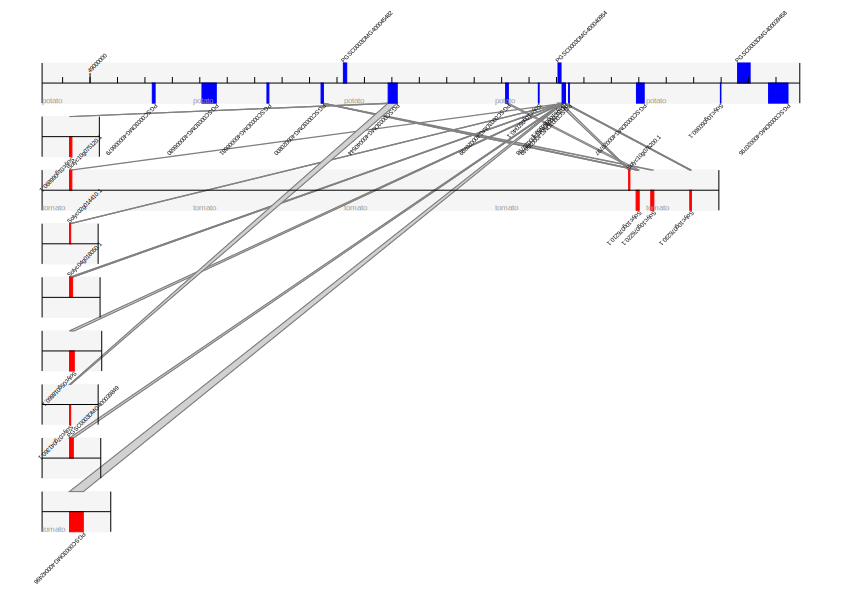

In [12]:
genesPdiagram = search.diagram_crosslinks("potato", "tomato", intervalP, genesP)
tmpFilename = "potato_"+tg1+"-"+tg2+".svg"
genesPdiagram.write(tmpFilename, "svg")
SVG(tmpFilename)

# Annotations
Compare GO annotatios in all three classes

Genes, orthologs for potato and tomato and annotations

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

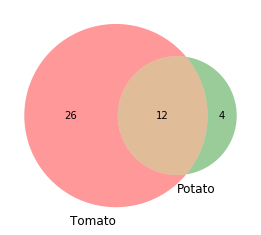

In [14]:
setT = genesT.index.unique()
setP = genesP.index.unique()
setTP = setT & genesP["ortholog_gene_id"].dropna().unique()
setPT = setP & genesT["ortholog_gene_id"].dropna().unique()
setT = list(set(setT)-set(setTP))
setP = list(set(setP)-set(setPT))
venn2(subsets = (len(setT), len(setTP), len(setP)), set_labels = ("Tomato", "Potato"))
#venn2(subsets = (1,2,3), set_labels = ("Tomato", "Potato"))
plt.show()

## Only in Tomato interval

In [15]:
print(*setT, sep = "\n")

PGSC0003DMG400011434
Solyc10g076190.1
Solyc10g076170.1
PGSC0003DMG400011435
Solyc10g076180.1
PGSC0003DMG400011433
PGSC0003DMG402011427
PGSC0003DMG400011439
PGSC0003DMG400011441
PGSC0003DMG400034736
PGSC0003DMG400011438
PGSC0003DMG400011431
PGSC0003DMG400011437
PGSC0003DMG400011440
PGSC0003DMG402011442
PGSC0003DMG400011429
PGSC0003DMG400011426
PGSC0003DMG400011430
PGSC0003DMG400011415
PGSC0003DMG400011414
PGSC0003DMG400011443
PGSC0003DMG400042748
PGSC0003DMG400011436
PGSC0003DMG400011413
PGSC0003DMG400011432
PGSC0003DMG401011427


In [16]:
termT = search.gene_annotations(setT)["term"].dropna().unique()
print(*termT, sep = "\n")

DNA binding
DNA-binding transcription factor activity
RNA binding
enoyl-[acyl-carrier-protein] reductase (NADH) activity
peroxidase activity
protein serine/threonine phosphatase activity
nucleus
plasma membrane
DNA repair
DNA recombination
transcription, DNA-templated
fatty acid biosynthetic process
response to oxidative stress
ADP binding
negative regulation of transcription, DNA-templated
metal ion binding
extracellular region
integral component of membrane
chloroplast
pollen development
embryo development ending in seed dormancy
sequence-specific DNA binding
heme binding
Smc5-Smc6 complex
hydrogen peroxide catabolic process
TIM22 mitochondrial import inner membrane insertion complex
protein import into mitochondrial inner membrane
clathrin-dependent endocytosis


In [17]:
termT = search.gene_annotations(setT).sort_index()
index=pd.MultiIndex.from_tuples([tuple(x) for x in termT[["term"]].to_records()], names=["gene_id", "term"])
display(termT.set_index(index).dropna()[[]].groupby(["gene_id","term"]).sum())

Empty DataFrame
Columns: []
Index: [(PGSC0003DMG400011413, DNA recombination), (PGSC0003DMG400011413, DNA repair), (PGSC0003DMG400011413, Smc5-Smc6 complex), (PGSC0003DMG400011413, nucleus), (PGSC0003DMG400011414, RNA binding), (PGSC0003DMG400011414, metal ion binding), (PGSC0003DMG400011415, chloroplast), (PGSC0003DMG400011415, clathrin-dependent endocytosis), (PGSC0003DMG400011415, plasma membrane), (PGSC0003DMG400011415, pollen development), (PGSC0003DMG400011430, DNA-binding transcription factor activity), (PGSC0003DMG400011430, sequence-specific DNA binding), (PGSC0003DMG400011430, transcription, DNA-templated), (PGSC0003DMG400011431, integral component of membrane), (PGSC0003DMG400011432, TIM22 mitochondrial import inner membrane insertion complex), (PGSC0003DMG400011432, integral component of membrane), (PGSC0003DMG400011432, protein import into mitochondrial inner membrane), (PGSC0003DMG400011433, DNA binding), (PGSC0003DMG400011433, metal ion binding), (PGSC0003DMG400011433, nucleus), (PGSC0003DMG400011434, DNA binding), (PGSC0003DMG400011435, DNA binding), (PGSC0003DMG400011435, nucleus), (PGSC0003DMG400011436, enoyl-[acyl-carrier-protein] reductase (NADH) activity), (PGSC0003DMG400011436, fatty acid biosynthetic process), (PGSC0003DMG400011437, embryo development ending in seed dormancy), (PGSC0003DMG400011438, embryo development ending in seed dormancy), (PGSC0003DMG400011439, embryo development ending in seed dormancy), (PGSC0003DMG400011440, metal ion binding), (PGSC0003DMG400011440, protein serine/threonine phosphatase activity), (PGSC0003DMG400011441, metal ion binding), (PGSC0003DMG400011441, protein serine/threonine phosphatase activity), (PGSC0003DMG400011443, protein serine/threonine phosphatase activity), (PGSC0003DMG401011427, ADP binding), (PGSC0003DMG402011427, ADP binding), (PGSC0003DMG402011442, metal ion binding), (PGSC0003DMG402011442, protein serine/threonine phosphatase activity), (Solyc10g076180.1, DNA binding), (Solyc10g076180.1, negative regulation of transcription, DNA-templated), (Solyc10g076190.1, extracellular region), (Solyc10g076190.1, heme binding), (Solyc10g076190.1, hydrogen peroxide catabolic process), (Solyc10g076190.1, metal ion binding), (Solyc10g076190.1, peroxidase activity), (Solyc10g076190.1, response to oxidative stress)]

## Only in Potato

In [18]:
print(*setP, sep = "\n")

PGSC0003DMG400020795
PGSC0003DMG400006681
PGSC0003DMG400039458
Solyc10g050340.1
PGSC0003DMG400020797
Solyc10g050360.1
PGSC0003DMG400006680
PGSC0003DMG400006679
PGSC0003DMG400045482
PGSC0003DMG400035649
PGSC0003DMG400040544
Solyc10g050350.1


In [19]:
termP = search.gene_annotations(setP)["term"].dropna().unique()
print(*termP, sep = "\n")

peroxidase activity
response to oxidative stress
metal ion binding
integral component of membrane
heme binding
hydrogen peroxide catabolic process


In [20]:
termP = search.gene_annotations(setP).sort_index()
index=pd.MultiIndex.from_tuples([tuple(x) for x in termP[["term"]].to_records()], names=["gene_id", "term"])
display(termP.set_index(index).dropna()[[]].groupby(["gene_id","term"]).sum())

Empty DataFrame
Columns: []
Index: [(PGSC0003DMG400006679, heme binding), (PGSC0003DMG400006679, hydrogen peroxide catabolic process), (PGSC0003DMG400006679, metal ion binding), (PGSC0003DMG400006679, peroxidase activity), (PGSC0003DMG400006679, response to oxidative stress), (PGSC0003DMG400006680, heme binding), (PGSC0003DMG400006680, peroxidase activity), (PGSC0003DMG400006680, response to oxidative stress), (PGSC0003DMG400006681, heme binding), (PGSC0003DMG400006681, peroxidase activity), (PGSC0003DMG400006681, response to oxidative stress), (PGSC0003DMG400020795, heme binding), (PGSC0003DMG400020795, peroxidase activity), (PGSC0003DMG400020795, response to oxidative stress), (Solyc10g050360.1, integral component of membrane)]

## Both in Tomato and Potato

In [21]:
print(*setTP, sep = "\n")
#print(*setPT, sep = "\n")

Solyc10g076200.1
Solyc10g076210.1
Solyc10g076220.1
Solyc10g076230.1


In [22]:
termTP = search.gene_annotations(setTP)["term"].dropna().unique()
print(*termTP, sep = "\n")

peroxidase activity
lipid transport
response to oxidative stress
lipid binding
metal ion binding
extracellular region
membrane
heme binding
hydrogen peroxide catabolic process


In [23]:
termTP = search.gene_annotations(setTP)
index=pd.MultiIndex.from_tuples([tuple(x) for x in termTP[["term"]].to_records()], names=["gene_id","term"])
display(termTP.set_index(index).dropna()[[]].groupby(["gene_id","term"]).sum())

Empty DataFrame
Columns: []
Index: [(Solyc10g076200.1, lipid binding), (Solyc10g076200.1, lipid transport), (Solyc10g076200.1, membrane), (Solyc10g076210.1, extracellular region), (Solyc10g076210.1, heme binding), (Solyc10g076210.1, hydrogen peroxide catabolic process), (Solyc10g076210.1, metal ion binding), (Solyc10g076210.1, peroxidase activity), (Solyc10g076210.1, response to oxidative stress), (Solyc10g076220.1, extracellular region), (Solyc10g076220.1, heme binding), (Solyc10g076220.1, hydrogen peroxide catabolic process), (Solyc10g076220.1, metal ion binding), (Solyc10g076220.1, peroxidase activity), (Solyc10g076220.1, response to oxidative stress), (Solyc10g076230.1, heme binding), (Solyc10g076230.1, peroxidase activity), (Solyc10g076230.1, response to oxidative stress)]

## Exploring the Annotations of Gene *Solyc10g076180.1*

- GO Annotation
- PPI 
- STRING
- KEGG
- ALL Orthologs
- Species with no Orthologs

In [24]:
genesTparalog = search.interval_genes(intervalT, True)
aggregations = { "ortholog_gene_id" : ["nunique"]}
display(genesTparalog.groupby(["gene_id"]).agg(aggregations))

EndPointInternalError: EndPointInternalError: endpoint returned code 500 and response. 

Response:
b'Virtuoso S1T00 Error SR171: Transaction timed out\n\nSPARQL query:\ndefine sql:big-data-const 0 \n#output-format:application/sparql-results+json\nPREFIX dc: <http://purl.org/dc/elements/1.1/>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX obo: <http://purl.obolibrary.org/obo/>\nPREFIX faldo: <http://biohackathon.org/resource/faldo#>\nPREFIX dcterms: <http://purl.org/dc/terms/>\nPREFIX ss: <http://semanticscience.org/resource/>\n\nSELECT DISTINCT\n   #main data\n   str(?gene_id) AS ?gene_id\n   str(?location_in_text) AS ?location\n   "chromosome 10" AS ?chrom\n   str(?begin_pos) AS ?begin_pos\n   str(?end_pos) AS ?end_pos\n   str(?ensembl_gene_id) AS ?ensembl_gene_id\n   str(?ensembl_location_in_text) AS ?ensembl_location\n   str(?ensembl_begin_pos) AS ?ensembl_begin_pos\n   str(?ensembl_begin_ref) AS ?ensembl_begin_ref\n   str(?ensembl_end_pos) AS ?ensembl_end_pos\n   str(?ensembl_end_ref) AS ?ensembl_end_ref\n   ?path\n   IF(?path="PARALOG",?paralog_gene_id, undef) AS ?paralog_gene_id\n   ?ortholog_gene_id AS ?ortholog_gene_id\n   ?ortholog_location_in_text AS ?ortholog_location\n   str(?ortholog_begin_pos) AS ?ortholog_begin_pos\n   str(?ortholog_begin_ref) AS ?ortholog_begin_ref\n   str(?ortholog_end_pos) AS ?ortholog_end_pos\n   str(?ortholog_end_ref) AS ?ortholog_end_ref\nFROM NAMED <http://solgenomics.net/genome/Solanum_tuberosum>\nFROM NAMED <http://solgenomics.net/genome/Solanum_lycopersicum>\nFROM NAMED <http://plants.ensembl.org/Solanum_lycopersicum>\nFROM NAMED <http://plants.ensembl.org/Solanum_tuberosum>\nWHERE {\n   GRAPH ?graphMain {\n      ?gene_uri dcterms:identifier ?gene_id;\n                a obo:SO_0001217;\n                rdfs:label ?label;\n                owl:sameAs ?ensembl_gene;\n                faldo:location ?location.\n      ?location rdfs:label ?location_in_text.\n      ?location faldo:begin ?begin;\n                faldo:end ?end.\n      ?begin faldo:position ?begin_pos;\n                faldo:reference/rdfs:label "chromosome 10"^^xsd:string. \n      ?end faldo:position ?end_pos.     \n   }   \n   FILTER( (xsd:integer(?begin_pos) > 58895882 ) && (xsd:integer(?end_pos) > 58895882 ) && (xsd:integer(?begin_pos) < 59082990 ) && (xsd:integer(?end_pos) < 59082990 ) )\n   OPTIONAL {\n     GRAPH ?graphOrthologOrigin {\n       ?ensembl_gene dc:identifier ?ensembl_gene_id;\n       faldo:location ?ensembl_location.\n       ?ensembl_location rdfs:label ?ensembl_location_in_text.\n       ?ensembl_location faldo:begin ?ensembl_begin;\n                faldo:end ?ensembl_end.\n       ?ensembl_begin faldo:position ?ensembl_begin_pos;\n                faldo:reference ?ensembl_begin_ref. \n       ?ensembl_end faldo:position ?ensembl_end_pos;\n                faldo:reference ?ensembl_end_ref.  \n     }\n     OPTIONAL {\n       GRAPH ?graphOrthologOrigin {\n         ?ensembl_gene ss:SIO_000630 ?paralog_gene.\n         ?paralog_gene dc:identifier ?paralog_gene_id.         \n         ?source_gene ss:SIO_000558 ?orthologs\n         BIND ( IF ( ?source_gene = ?ensembl_gene, "ORTHOLOG", "PARALOG") AS ?path )\n         FILTER(?source_gene IN (?ensembl_gene, ?paralog_gene))  \n       }    \n       GRAPH ?graphOrthologTarget {\n         ?orthologs dc:identifier ?ortholog_gene_id;\n                faldo:location ?ortholog_location.\n         ?ortholog_location rdfs:label ?ortholog_location_in_text.\n         ?ortholog_location faldo:begin ?ortholog_begin;\n                faldo:end ?ortholog_end.\n         ?ortholog_begin faldo:position ?ortholog_begin_pos;\n                faldo:reference ?ortholog_begin_ref. \n         ?ortholog_end faldo:position ?ortholog_end_pos;\n                faldo:reference ?ortholog_end_ref.     \n       }\n     }  \n   }\n}\nORDER BY ASC(?begin_pos)\n'

In [ ]:
index=pd.MultiIndex.from_tuples([tuple(x) for x in genesTparalog[["location","ensembl_gene_id", "paralog_gene_id", "ortholog_gene_id"]].to_records()], names=["gene_id", "location", "ensembl_gene_id", "paralog_gene_id", "ortholog_gene_id"])
display(genesTparalog.set_index(index)[["path", "ortholog_location"]])      